# Molecular graph generation with PyTorch and PyGeometric
> We use [GraphVAE](https://arxiv.org/abs/1802.03480) for molecular generation with one shot generation of a probabilistic graph with predefined maximum size. 

- toc: true 
- badges: true
- comments: false
- author: Anirudh Jain
- categories: [graph generation, pytorch, pygeometric, tutorial]

# Requirements

The following packages need to be installed:
- rdkit
- pytorch
- torch_geometric
- networkx

In [22]:
#collapse-hide

#Initial imports

import numpy as np
import torch
import matplotlib.pyplot as plt
from glob import glob
import tqdm
from rdkit import Chem 
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from torch.utils.data import Dataset, DataLoader
import torch
from torch_geometric.data import Batch
from torch.utils.data import random_split

# Introduction

We represent a molecule as graph $G = (\mathcal{X, A})$ using PyGeometric framework. Each molecule is represented by a feature matrix $\mathcal{X}$ and adjacency matrix $\mathcal{A}$. We use QM9 dataset from [MoleculeNet:A Benchmark for Molecular Machine Learning](https://arxiv.org/abs/1703.00564) implemented in `torch_geometric.datasets.QM9`. PyGeometric relies on rdkit to process the SMILES string and convert them into graphs.

We modify the data processing script in two ways:
- We strip hydrogen atoms from the molecules to keep only the heavy atoms
- We kekulize the molecules to convert aromatic rings to Kekule form

The modified script can be found [here](https://gist.github.com/sponde25/7dfa5492c21c007cf1e60a02dced1334)

After processing the dataset, we have a set of molecules with 4 heavy atoms (C, N, O, F) and 3 bond types (SINGLE, DOUBLE and TRIPLE) with maximum graph size of 9. 

The decoder outputs the graph as one-hot encoded vectors for atoms `[9 x 5]` and bonds `[9 x 4]`. The label 0 represents empty atom or edge.  

In [3]:
#Imports for data pre-processing

import torch_geometric
from qm9_modified import QM9
from torch_geometric.utils.convert import to_networkx
import networkx

In [4]:
# Setting up variables for the dataset

MAX_ATOM = 5 
MAX_EDGE = 4 
path = '/scratch/project_2002655/datasets/qm9_noH' # Change the path for your local directory structure
dataset = QM9(path)

# Store the max. graph size
MAX_N = -1
for data in dataset:
    if MAX_N < data.x.shape[0]: MAX_N = data.x.shape[0]
MAX_E = int(MAX_N * (MAX_N - 1))
print('MAX ATOMS: {}'.format(MAX_N))    # Maximum number of atoms in a graph in the dataset
print('MAX EDGE: {}'.format(MAX_E))     # Corresponding size of upper triangle adjacency matrix 

MAX ATOMS: 9
MAX EDGE: 72


`torch_geometric` stores the graph as `torch_geometric.data.Data` and we generate the one-hot representation of the graph $G$ as described above. For each graph $G$, we create a vector $\mathcal{X}$ as one-hot encoded for atom of dimension `[MAX_N x MAX_ATOM]` and vector bond of dimension `[MAX_E x MAX_EDGE]`.

![](../images/graphvae/data_representation.png "A visualization of the graph, atom and edge representations")

In [5]:
# We create a matrix to map the index of the edge vector $\mathcal{A}$ to the upper triangular adjacency matrix.

index_array = torch.zeros([MAX_N, MAX_N], dtype=int)
idx = 0
for i in range(MAX_N):
    for j in range(MAX_N):
        if i < j:
            index_array[i, j] = idx
            idx+=1

print(index_array)

tensor([[ 0,  0,  1,  2,  3,  4,  5,  6,  7],
        [ 0,  0,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  0,  0, 15, 16, 17, 18, 19, 20],
        [ 0,  0,  0,  0, 21, 22, 23, 24, 25],
        [ 0,  0,  0,  0,  0, 26, 27, 28, 29],
        [ 0,  0,  0,  0,  0,  0, 30, 31, 32],
        [ 0,  0,  0,  0,  0,  0,  0, 33, 34],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 35],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])


We process the `torch_geometric.dataset` to generate matrices $\mathcal{X}$ and $\mathcal{A}$ which act as the ground truth for our decoder. We will also setup utility functions to convert between the vector representation $(\mathcal{X}, \mathcal{A})$ and `torch_geometric.data` representation $\mathcal{G}$. We use the following key for atoms and bonds:
```
    C: 1    SINGLE: 1
    N: 2    DOUBLE: 2
    O: 3    TRIPLE: 3
    F: 4
```
`0` is the placeholder label for empty entry.

In [6]:
# Initialize the labels with -1
edge_labels = torch.ones(len(dataset), MAX_E) * -1
atom_labels = torch.ones(len(dataset), MAX_N) * -1
idx = 0
for data in dataset:
    edge_attr = data.edge_attr      # One hot encoded bond labels
    edge_index = data.edge_index    # Bond indices as one hot adjacency list
    upper_index = edge_index[0] < edge_index[1] # Bond indices as upper triangular adjacency matrix
    _, edge_label = torch.max(edge_attr, dim=-1)# Bond labels from one hot vectors
    x = data.x[:, 1:5]              # One hot encoded atom labels
    _, atom_label = torch.max(x, dim=-1)        # Atom labels from one hot vectors
    # Expand the label vectors to size [MAX_N x MAX_ATOM] and [MAX_E x MAX_EDGE]
    atom_labels[idx][:len(atom_label)] = atom_label
    a0 = edge_index[0,upper_index]
    a1 = edge_index[1,upper_index]
    up_idx = index_array[a0, a1]
    edge_labels[idx][up_idx] = edge_label[upper_index].float()
    idx += 1

atom_labels += 1
edge_labels += 1

Now that we have the dataset represented as $(\mathcal{X}, \mathcal{A})$ let's plot some graphs to visually check if the molecules are as we expected. We use `rdkit` to plot the molecules which does a lot of having lifting for us. The function `graphToMol` takes in the vectors $(\mathcal{X}, \mathcal{A})$ and returns an object of type `rdkit.Mol`. We can also obtain visualizations for the graphs $\mathcal{G}$ by using `torch_geometric.utils.convert.to_networkx` and then ploting the netowrkx graph. But `rdkit` plots the molecules in a canonical orientation and is built to minimize intramolecular clashes, i.e. to maximize the clarity of the drawing.

In [7]:
#collapse-hide

def get_index(index, index_array):
    for i in range(9):
        for j in range(9):
            if i < j:
                if(index_array[i, j] == index):
                    return [i, j]

def graphToMol(atom, edge):

    possible_atoms = {
        0: 'H',
        1: 'C',
        2: 'N',
        3: 'O',
        4: 'F'
    }
    possible_edges = {
        1: Chem.rdchem.BondType.SINGLE, 
        2: Chem.rdchem.BondType.DOUBLE, 
        3: Chem.rdchem.BondType.TRIPLE
    }
    max_n = 9
    
    mol = Chem.RWMol()
    rem_idxs = []
    for a in atom:    
        atom_symbol = possible_atoms[a.item()]
        mol.AddAtom(Chem.Atom(atom_symbol))
    for a in mol.GetAtoms():
        if a.GetAtomicNum() == 1:
            rem_idxs.append(a.GetIdx())
    for i, e in enumerate(edge):
        e = e.item()
        if e != 0:
            a0, a1 = get_index(i, index_array)
            if a0 in rem_idxs or a1 in rem_idxs:
                return None
            bond_type = possible_edges[e]
            mol.AddBond(a0, a1, order=bond_type)
    rem_idxs.sort(reverse=True)
    for i in rem_idxs:
        mol.RemoveAtom(i)
    return mol

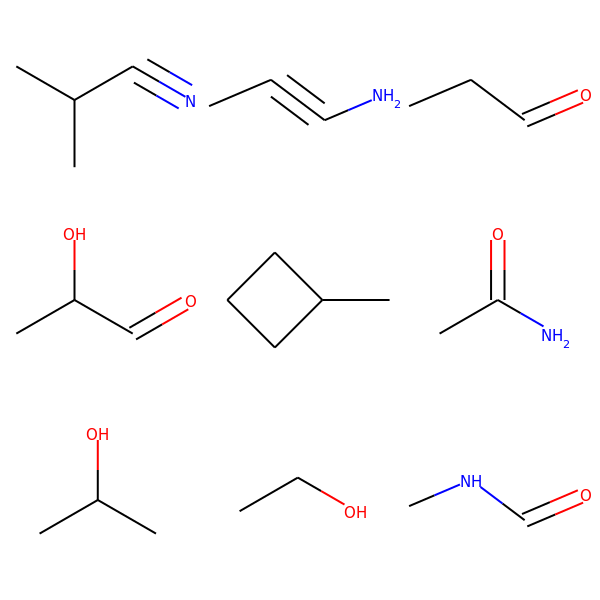

In [20]:
# We pick 9 random molecules from QM9 dataset to plot
mols = []
for i in np.random.randint(0, 100, size=9):
    mols.append(graphToMol(atom_labels[i], edge_labels[i]))
Chem.Draw.IPythonConsole.ShowMols(mols)

The final step is to create a custom dataset for PyTorch which combines the two representations $\mathcal{G}$ and $(\mathcal{X}, \mathcal{A})$. The dataset returns a list containing the graph, atom label and edge label. We also define a `collate_fn` which creates mini batches for the data loader that we will need for training and testing our model.

In [23]:
#collapse-hide

# Utility function to combine the torch_geometric.data and torch.tensor into one mini batch
def collate_fn(datas):
    graphs, atoms, edges = [], [], []
    for data in datas:
        graph, atom, edge = data
        graphs.append(graph)
        atoms.append(atom)
        edges.append(edge)
    graphs = Batch.from_data_list(graphs)
    atoms = torch.stack(atoms)
    edges = torch.stack(edges)
    return graphs, atoms, edges

# Returns the dataloader with a given batch size
def get_dataloader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Create the dataset from the QM9 dataset from PyGeometric and the label matrices
class GraphTensorDataset(Dataset):

    def __init__(self):

        self.graph_dataset = QM9('/scratch/project_2002655/datasets/qm9_noH')
        self.atom_labels = torch.load('/scratch/project_2002655/drug_discovery/saved/atom_labels_noH.tensor')
        self.edge_labels = torch.load('/scratch/project_2002655/drug_discovery/saved/edge_labels_noH.tensor')

    def __len__(self):
        return len(self.graph_dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        graphs = self.graph_dataset[idx]
        atoms = self.atom_labels[idx]
        edges = self.edge_labels[idx]

        return graphs, atoms, edges
    
    # return the subset of data with the specified size
    def get_splits(self, train_size, test_size, cv_size=None):
        total_data = len(self.graph_dataset)
        if cv_size is not None:
            trainset, testset = random_split(self, [train_size+cv_size, total_data - train_size - cv_size])
            trainset, cvset = random_split(trainset, [train_size, cv_size])
            testset, _ = random_split(testset, [test_size, len(testset) - test_size])
            self.trainset = trainset
            self.cvset = cvset
            self.testset = testset
            return self.trainset, self.testset, self.cvset
        else:
            trainset, testset = random_split(self, [train_size, total_data - train_size])
            testset, _ = random_split(testset, [test_size, len(testset) - test_size])
            self.trainset = trainset
            self.testset = testset
            return self.trainset, self.testset


Now we wrap up this section by creating the train and test loaders with a mini batch of size `32`. We train the model on a subset of 500 molecules and test the reconstruction on 10000 molecules. To monitor training we look at three metrics averaged over the minibatch:
- cross-entropy loss over the atom and edge labels
- Atom label accuracy
- Edge label accuracy 

In [24]:
dataset = GraphTensorDataset()
train_size = int(500)
test_size = int(10000)
torch.manual_seed(0) # We set the random seed before the random split so we can get the same subset for reproducibility 
trainset, testset = dataset.get_splits(train_size, test_size)
trainloader = get_dataloader(trainset)
testloader = get_dataloader(testset)

# Model

Our generative model is a VAE with an encoder $q_\phi (\textbf{z} | \mathcal{G})$ and a decoder $p_\theta (\mathcal{X}, \mathcal{A} | \textbf{z})$ parameterized by $\phi$ and $\theta$ respectively. We place a prior over the latent vector $\textbf{z} \sim \mathcal{N}(0, I)$ which act as a regularizer to our model. Our goal is to map the graph $\mathcal{G}$ into the latent vector $\textbf{z}$ and generate new graphs by using the decoder to map new latent vectors sampled from the prior.

***Encoder***: For a graph $\mathcal{G}(\mathcal{V}, \mathcal{E})$ with upto N nodes, we aim to map the graph to a latent vector $\textbf{z} \in \mathbb{R}^D$. We use graph convolution network(GCN) to learn graph level feature vector $h_{\mathcal{G}}$. For each node $\mathcal{v} \in \mathcal{V}$, GCN update the node level features as,
\begin{equation}
    h_{\mathcal{v}} = \sum_{\mathcal{u} \in Nbd(\mathcal{v}, \mathcal{G})}\Phi (W_l^T X_{\mathcal{u}})
\end{equation}
where $Nbd(\mathcal{v}, \mathcal{G})$ is the neighborhood of node $\mathcal{v}$ in graph $\mathcal{G}$, $W_l$ are the shared weights analogous to the kernel in convolution layer and $X_\mathcal{u}$ is the feature vector of node $\mathcal{u}$ with $\Phi$ as the non-linearity.

After 2 graph convolution layers, we create a graph level vector representation by taking the mean of all node feature vectors $h_{\mathcal{v}}$.
\begin{equation}
    h_{\mathcal{G}} = 1 / |\mathcal{V}| \sum_{\mathcal{v} \in \mathcal{V}} h_{\mathcal{v}}
\end{equation}
Now we use fully connected layers to learn the latent vector $\textbf{z}$ with the inference model as,
\begin{equation}
    q(\textbf{z}|\mathcal{G}) = \mathcal{N}(\textbf{z}|\mu(h_{\mathcal{G}}), \sigma^2(h_{\mathcal{G}}))
\end{equation}
where $\mu(h_{\mathcal{G}})$ and $\sigma^2(h_{\mathcal{G}})$ are parameterized by neural networks to learn the latent space.

![](../images/graphvae/encoder_arch.png "Visualization of the encoder architecture")

***Decoder***: The primary problem with graph generation is that order of nodes can be arbritary which makes comparing two graphs a combatorial problem. We sidestep this problem by framing the graph generation problem as multi class classification problem. Keeping in the spirit of a toy example, we consider two independent classification problems. 

We train a decoder to predict atom and edge label vectors $(\mathcal{X}, \mathcal{A})$ respectively. We can train the model by using the standard VAE loss,
\begin{equation}
    \mathcal{L} = \alpha_{\mathcal{a}} \mathcal{L}_{\mathcal{a}} + \alpha_\mathcal{e} \mathcal{L}_{\mathcal{e}} + \alpha_{KL} KL[q(\textbf{z}|\mathcal{G}) | p(\textbf{z})]
\end{equation}

$\mathcal{L}_{\mathcal{a}}$ and $\mathcal{L}_{\mathcal{e}}$ are the cross entropy loss for multiclass vectors for atoms and edges respectively. This restricts the decoder to memorize the ordering for the atom labels and independently learn the edges based only on the latent vector $\textbf{z}$. We set $\alpha_\mathcal{a} = 1/|\mathcal{X}|$, $\alpha_\mathcal{e} = 1/|{\mathcal{A}}|$ and $\alpha_KL = 1/ 128$ so all three loses are on the same scale. $\mathcal{X}$ is the number of atoms in a mini batch, $|\mathcal{A}|$ is the number of edges in a mini batch and we set the dimension of the latent vector as $128$.

We use a single sample from the latent distribution to train the VAE and 100 samples during testing.

![](../images/graphvae/decoder_arch.png "Visualization of the decoder architecture")

In [1]:
#collapse-hide

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, BatchNorm, GlobalAttention
from torch_geometric.utils import add_self_loops 

class VAE(nn.Module):
    def __init__(self,  max_n, max_atoms, max_edges, in_features):
        super(VAE, self).__init__()
        n_output = int(max_n * (max_n - 1) / 2)
        self.n_output = n_output
        self.max_n = max_n
        self.max_atoms = max_atoms
        self.max_edges = max_edges

        self.gc1 = GCNConv(in_features, 32)
        self.gc2 = GCNConv(32, 64)
        self.gc1_bn = nn.BatchNorm1d(32)
        self.gc2_bn = nn.BatchNorm1d(64)

        attn1 = nn.Linear(64, 1)
        attn2 = nn.Linear(64, 64)
        self.graph_pool = GlobalAttention(attn1, attn2)

        self.fc1 = nn.Linear(64, 128)
        self.fc1_bn = nn.BatchNorm1d(128)

        self.mu = nn.Linear(128, 128)
        self.logv = nn.Linear(128, 128)

        self.dec1 = nn.Linear(128, 128)
        self.dec1_bn = nn.BatchNorm1d(128)
        self.dec2 = nn.Linear(128, 256)
        self.dec2_bn = nn.BatchNorm1d(256)
        self.dec3 = nn.Linear(256, 512)
        self.dec3_bn = nn.BatchNorm1d(512)

        self.atoms = nn.Linear(512, max_atoms*max_n)
        self.edges = nn.Linear(512, max_edges*n_output)

    def encode(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_index, _ = add_self_loops(edge_index)

        x = self.gc1(x, edge_index)
        x = F.relu(self.gc1_bn(x))
        x = self.gc2(x, edge_index)
        x = F.relu(self.gc2_bn(x))
        #x = self.graph_pool(x, batch)
        #x = F.tanh(x)
        x = torch_geometric.nn.global_add_pool(x, data.batch)
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        return self.mu(x), self.logv(x)

    def sample(self, mu, logv):
        eps = torch.randn_like(logv).to(mu.device)
        return mu + eps * torch.exp(logv)

    def decode(self, sample):
        x = self.dec1(sample)
        x = F.relu(self.dec1_bn(x))
        x = self.dec2(x)
        x = F.relu(self.dec2_bn(x))
        x = self.dec3(x)
        x = F.relu(self.dec3_bn(x))
        
        atoms = self.atoms(x)
        atoms = atoms.view(-1, self.max_n, self.max_atoms)
        atoms = F.softmax(atoms, dim=-1)

        edges = self.edges(x)
        edges = edges.view(-1, self.n_output, self.max_edges)
        edges = F.softmax(edges, dim=-1)
        return atoms, edges

    def forward(self, data, num_samples=1):
        mu, logv = self.encode(data)
        _atoms, _edges = [], []
        for i in range(num_samples):
            sample = self.sample(mu, logv)
            atoms, edges = self.decode(sample)
            _atoms.append(atoms)
            _edges.append(edges)      
        return mu, logv, _atoms, _edges

Now that we have the dataloader and the model, we can setup utility functions `train` and `test` along with the metrics that we need to evaluate the model performance. We use multi class accuracy to monitor as an indicator for model performance.   

In [2]:
#collapse-hide

from pathlib import Path

# KL loss for the latent vector
def get_vae_loss(mu, logv):
    kl_loss = 0.5 * torch.sum(torch.exp(logv) + mu**2 - 1.0 - logv)
    return kl_loss/128

# Reconstruction loss for atom and edge vectors
def get_recon_loss(atom_true, atom_prob, edge_true, edge_prob):
    ashape = atom_prob.shape
    num_atoms = (atom_true!=0).int().sum()
    atom_prob = torch.log(atom_prob)
    atom_loss = F.nll_loss(atom_prob.view(-1, ashape[-1]), 
                                atom_true.view(-1).long(), reduction='sum') / num_atoms
    eshape = edge_prob.shape
    edge_prob = torch.log(edge_prob)
    num_edges = (edge_true!=0).int().sum()
    edge_loss = F.nll_loss(edge_prob.view(-1, eshape[-1]), 
                                edge_true.view(-1).long(), reduction='sum') / num_edges
    return atom_loss, edge_loss

# Return the correct predictions for multi class label classification
def get_accuracy(y_true, y_prob, threshold = 0.5):
    if len(y_prob.shape) <=2:
        y_pred = (y_prob >= threshold).int()
    else:
        _, y_pred = torch.max(y_prob, dim=-1)
    index = y_true != 0
    correct = y_true[index] == y_pred[index]
    return correct.int().sum(), index.int().sum()

# Class to run and store training statistics we can monitor for model performance
class Experiment():
    def __init__(self, model, optimizer, path = './saved/tmp/'):
        self.model = model
        self.optimizer = optimizer
        self.path = path

        Path(path+'models/').mkdir(parents=True, exist_ok=True)
        Path(path+'metrics/').mkdir(parents=True, exist_ok=True)
        Path(path+'figs/').mkdir(parents=True, exist_ok=True)

        self.trainLoss = []
        self.trainAcc = []
        self.trainAUC = []
        self.trainLossBatch = []
        self.trainAccBatch = []
        self.betaBatch = []
        self.testLoss = []
        self.testAcc = []
        self.testAUC = []
        self.testLossBatch = []
        self.testAccBatch = []

    def train(self, dataloader, epoch, cyclic = False, device = 'cuda'):
        self.model.train()
        
        total_data = len(dataloader.dataset)
        total_batches = len(dataloader)
        batch_idx = epoch * total_batches
        if cyclic:
            batches_cycle = int(total_batches / 3)
            batches_half_cycle = int(batches_cycle / 2)
            betas = np.ones(batches_cycle)
            betas[:batches_half_cycle] = np.linspace(0, 1, num=batches_half_cycle)
        atom_correct = atom_total = edge_correct = edge_total = 0.
        atom_auc = edge_auc = 0.
        kl_loss = atom_loss = edge_loss = 0.
        beta = 1

        for data in dataloader:
            graph = data[0].to(device)
            atom_true = data[1].to(device)
            edge_true = data[2].to(device)
            batch_size = atom_true.shape[0]

            # Core Training
            self.optimizer.zero_grad()
            mu, logv, atom_probs, edge_probs = self.model(graph)
            _kl_loss = get_vae_loss(mu, logv)
            aloss = eloss = 0.
            for atom_prob, edge_prob in zip(atom_probs, edge_probs):
                _atom_loss, _edge_loss = get_recon_loss(atom_true, atom_prob, edge_true, edge_prob)
                aloss += _atom_loss
                eloss += _edge_loss
            C = len(atom_probs)
            _atom_loss = aloss / C
            _edge_loss = eloss / C
            _recon_loss = _atom_loss + _edge_loss
            if cyclic:
                beta_idx = batch_idx % batches_cycle
                beta = betas[beta_idx]
            loss = _kl_loss * beta + _recon_loss 
            loss.backward()
            self.optimizer.step()
            batch_idx += 1

            with torch.no_grad():
                self.trainLossBatch.append([_kl_loss, _atom_loss, _edge_loss])
                self.betaBatch.append(beta)

                kl_loss += _kl_loss.item() * batch_size
                atom_loss += _atom_loss.item() * batch_size
                edge_loss += _edge_loss.item() * batch_size
                _atom_correct = _edge_correct = _atom_auc = _edge_auc = 0.
                C = len(atom_probs)
                for atom_prob, edge_prob in zip(atom_probs, edge_probs):
                    acorrect, _atom_total = get_accuracy(atom_true, atom_prob)
                    ecorrect, _edge_total = get_accuracy(edge_true, edge_prob)
                    aauc = get_multi_auc(atom_true.cpu(), atom_prob.cpu(), atom_prob.shape[-1]) * batch_size
                    eauc = get_multi_auc(edge_true.cpu(), edge_prob.cpu(), edge_prob.shape[-1]) * batch_size
                    _atom_correct += acorrect
                    _edge_correct += ecorrect
                    _atom_auc += aauc 
                    _edge_auc += eauc 
                atom_auc += _atom_auc.item() / C
                edge_auc += _edge_auc.item() / C
                atom_correct += _atom_correct.item() / C
                atom_total += _atom_total.item() 
                edge_correct += _edge_correct.item() / C
                edge_total += _edge_total.item()

                self.trainAccBatch.append([_atom_correct/C/_atom_total, _edge_correct/C/_edge_total])
        
        self.trainLoss.append([kl_loss/total_data, atom_loss/total_data, edge_loss/total_data])
        self.trainAcc.append([atom_correct/atom_total, edge_correct/edge_total])
        self.trainAUC.append([atom_auc/total_data, edge_auc/total_data])

    def test(self, dataloader, epoch, num_samples = 1, device = 'cuda'):
        self.model.eval()

        with torch.no_grad():
            kl_loss = 0.
            atom_loss = 0.
            edge_loss = 0.
            total_data = len(dataloader.dataset)
            total_batches = len(dataloader)
            batch_idx = epoch * total_batches
            atom_correct = atom_total = edge_correct = edge_total = 0.
            atom_auc = edge_auc = 0.

            for data in dataloader:
                graph = data[0].to(device)
                atom_true = data[1].to(device)
                edge_true = data[2].to(device)
                batch_size = atom_true.shape[0]

                mu, logv, atom_probs, edge_probs = self.model(graph, num_samples)
                _kl_loss = get_vae_loss(mu, logv)
                aloss = eloss = 0.
                for atom_prob, edge_prob in zip(atom_probs, edge_probs):
                    _atom_loss, _edge_loss = get_recon_loss(atom_true, atom_prob, edge_true, edge_prob)
                    aloss += _atom_loss
                    eloss += _edge_loss
                C = len(atom_probs)
                _atom_loss = aloss / C
                _edge_loss = eloss / C

                kl_loss += _kl_loss.item() * batch_size
                atom_loss += _atom_loss.item() * batch_size
                edge_loss += _edge_loss.item() * batch_size
                _atom_correct = _edge_correct = _atom_auc = _edge_auc = 0.
                C = len(atom_probs)
                for atom_prob, edge_prob in zip(atom_probs, edge_probs):
                    acorrect, _atom_total = get_accuracy(atom_true, atom_prob)
                    ecorrect, _edge_total = get_accuracy(edge_true, edge_prob)
                    aauc = get_multi_auc(atom_true.cpu(), atom_prob.cpu(), atom_prob.shape[-1]) * batch_size
                    eauc = get_multi_auc(edge_true.cpu(), edge_prob.cpu(), edge_prob.shape[-1]) * batch_size
                    _atom_correct += acorrect
                    _edge_correct += ecorrect
                    _atom_auc += aauc 
                    _edge_auc += eauc
                atom_auc += _atom_auc.item() / C
                edge_auc += _edge_auc.item() / C
                atom_correct += _atom_correct.item() / C
                atom_total += _atom_total.item() 
                edge_correct += _edge_correct.item() / C
                edge_total += _edge_total.item()

                self.testLossBatch.append([_kl_loss, _atom_loss, _edge_loss])
                self.testAccBatch.append([_atom_correct/_atom_total, _edge_correct/_edge_total])

            self.testLoss.append([kl_loss/total_data, atom_loss/total_data, edge_loss/total_data])
            self.testAcc.append([atom_correct/atom_total, edge_correct/edge_total])
            self.testAUC.append([atom_auc/total_data, edge_auc/total_data])

    def save_state(self, epoch):
        metrics = {}
        trainLoss = np.array(self.trainLoss)
        trainAcc = np.array(self.trainAcc)
        trainAUC = np.array(self.trainAUC)
        testLoss = np.array(self.testLoss)
        testAcc = np.array(self.testAcc)
        testAUC = np.array(self.testAUC)

        metrics['Train KL Loss'] = trainLoss[:, 0]
        metrics['Train Atom Loss'] = trainLoss[:, 1]
        metrics['Train Edge Loss'] = trainLoss[:, 2]

        metrics['Train Atom Acc'] = trainAcc[:, 0]
        metrics['Train Edge Acc'] = trainAcc[:, 1]

        metrics['Train Atom AUC'] = trainAUC[:, 0]
        metrics['Train Edge AUC'] = trainAUC[:, 1]

        metrics['Test KL Loss'] = testLoss[:, 0]
        metrics['Test Atom Loss'] = testLoss[:, 1]
        metrics['Test Edge Loss'] = testLoss[:, 2]

        metrics['Test Atom Acc'] = testAcc[:, 0]
        metrics['Test Edge Acc'] = testAcc[:, 1]

        metrics['Test Atom AUC'] = testAUC[:, 0]
        metrics['Test Edge AUC'] = testAUC[:, 1]

        torch.save(metrics, self.path + 'metrics/epoch_{}.metric'.format(epoch))

        batch_metrics = {}
        trainLossBatch = np.array(self.trainLossBatch)
        trainAccBatch = np.array(self.trainAccBatch)
        testLossBatch = np.array(self.testLossBatch)
        testAccBatch = np.array(self.testAccBatch)

        batch_metrics['Train KL Loss'] = trainLossBatch[:, 0]
        batch_metrics['Train Atom Loss'] = trainLossBatch[:, 1]
        batch_metrics['Train Edge Loss'] = trainLossBatch[:, 2]

        batch_metrics['Train Atom Acc'] = trainAccBatch[:, 0]
        batch_metrics['Train Edge Acc'] = trainAccBatch[:, 1]

        batch_metrics['Test KL Loss'] = testLossBatch[:, 0]
        batch_metrics['Test Atom Loss'] = testLossBatch[:, 1]
        batch_metrics['Test Edge Loss'] = testLossBatch[:, 2]

        batch_metrics['Test Atom Acc'] = testAccBatch[:, 0]
        batch_metrics['Test Edge Acc'] = testAccBatch[:, 1]
        
        torch.save(batch_metrics, self.path + 'metrics/batches.metric')
        
        torch.save(self.model.state_dict(), self.path + 'models/gvae_{}.model'.format(epoch))

We can use many tricks from the VAE literature to improve performance and obtain better results. [Cyclic Annealing Schedule](https://arxiv.org/abs/1903.10145) for VAE training has been show to significantly improve performance on autoregressive NLP tasks such as language modeling, dialog response generation etc. We can train the model using cyclic annealing schedule by setting the flag `cyclic=True`.

We use the mean of 40 samples during testing to calculate the loss and accuracy on the test set.

In [ ]:
model = VAE(MAX_N, MAX_ATOM, MAX_EDGE, 13)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
epochs = 100
device = 'cuda'
model = model.to(device)
path = './saved/test/'
experiment = Experiment(model, optimizer, path)

for epoch in range(epochs):
    
    experiment.train(trainloader, epoch, cyclic=False)
    experiment.test(testloader, epoch, 40)
    experiment.save_state(epoch)

# Results

We train the model on the dataset of 500 molecules and test on a dataset of 10,000 molecules for 100 epochs. The small size of the trainset leads to a large generalization gap and the model overfits on trainset with the atom and edge cross entropy loss decreasing but a flat test loss. The test atom classification accuracy converges at around 80% while the edge classification accuracy converges at around 75%. We only consider the labels with non-zero entry in the ground truth to calculate accuracy.

![](../images/graphvae/train_test_curves.png "The train and test curves for the graphVAE model")

Now we consider metrics to check the generative performance for molecules. We sample $n_s = 10,000$ latent vectors $\textbf{z}$ from the prior $\mathcal{N}(0, I)$ and use the trained decoder to generate new molecules. We use the following three metrics to test the quality of the learned latent space:
- Validity:     Let list $|V|$ represent chemically valid molecules, validity is the ratio $|V|/n_s$
- Uniqueness:   The set of chemically valid molecules $U = set(V)$, uniqueness is the ratio $|U|/|V|$
- Novelty:      Novelty is the set of elements in $U$ not in the trainset $\mathcal{D}_{train}$ defined as $1 - (U \cap \mathcal{D}_{train})/|U|$

We obtain the following results from our trained model:


| Validity | Uniqueness | Novelty| 
|----------|-----------|---------|
|    62.33%|   76.40%  |  66.71% |

Even the simple toy example can generate a substantial number of unique and novel valid molecules. This is without any graph matching in the loss function so the model can learn to predict nodes in arbritary order and is restricted by the order of nodes in the trainset. Also these results are obtained from a very small subset of data and is comparable to [GraphAF](https://arxiv.org/abs/2001.09382) without validity checks during training as they report validity of 67% in Table 3

# Conclusion